<a href="https://colab.research.google.com/github/lagamaite/Colab-Notebooks/blob/master/RNN_with_np_random_and_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import collections
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.keras import layers

In [0]:
model = tf.keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units. -> long tern short memory
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


In [0]:
#Second model with extraq layers

model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
#tf.keras.layers.RNN generic class makes it easy to create custom architecture
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 256)         247296    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


In [0]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None, ))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(encoder_input)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(
    64, return_state=True, name='encoder')(encoder_embedded)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None, ))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(decoder_input)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(
    64, name='decoder')(decoder_embedded, initial_state=encoder_state)
output = layers.Dense(10)(decoder_output)

model = tf.keras.Model([encoder_input, decoder_input], output)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     64000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     128000      input_2[0][0]                    
______________________________________________________________________________________________

In [0]:
# generating random data
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
lstm_layer.reset_states()


In [0]:
model = tf.keras.Sequential()


# bidirectional- can not only feed forward but also backwards
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True), 
                               input_shape=(5, 10)))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 128)            38400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


In [0]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
  # CuDNN is only available at the layer level, and not at the cell level.
  # This means `LSTM(units)` will use the CuDNN kernel,
  # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
  if allow_cudnn_kernel:
    # The LSTM layer with default options uses CuDNN.
    lstm_layer = tf.keras.layers.LSTM(units, input_shape=(None, input_dim))
  else:
    # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
    lstm_layer = tf.keras.layers.RNN(
        tf.keras.layers.LSTMCell(units),
        input_shape=(None, input_dim))
  model = tf.keras.models.Sequential([
      lstm_layer,
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(output_size)]
  )
  return model


In [0]:
# load mnist
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
model = build_model(allow_cudnn_kernel=True)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer='sgd',
              metrics=['accuracy'])


In [0]:
#train model with 5 epochs (remember val_acc = validation set accuracy)
# validation accuacy goes up and down whereas 
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=5)


Epoch 1/5
938/938 [==============================] - 20s 21ms/step - loss: 0.9428 - accuracy: 0.6987 - val_loss: 0.5109 - val_accuracy: 0.8441
Epoch 2/5
938/938 [==============================] - 20s 21ms/step - loss: 0.4014 - accuracy: 0.8788 - val_loss: 0.2869 - val_accuracy: 0.9121
Epoch 3/5
938/938 [==============================] - 20s 21ms/step - loss: 0.2597 - accuracy: 0.9211 - val_loss: 0.3149 - val_accuracy: 0.8961
Epoch 4/5
938/938 [==============================] - 20s 21ms/step - loss: 0.2074 - accuracy: 0.9371 - val_loss: 0.3249 - val_accuracy: 0.8819
Epoch 5/5
938/938 [==============================] - 20s 21ms/step - loss: 0.1762 - accuracy: 0.9466 - val_loss: 0.1829 - val_accuracy: 0.9411


In [0]:
# this model does not use CUDA, just the normal tensorflow kernel to train, runs on CPU by default
slow_model = build_model(allow_cudnn_kernel=False)
slow_model.set_weights(model.get_weights())
slow_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # loss function for the model
                   optimizer='sgd', 
                   metrics=['accuracy'])
slow_model.fit(x_train, y_train, 
               validation_data=(x_test, y_test), 
               batch_size=batch_size,
               epochs=1)  # We only train for one epoch because it's slower.


938/938 [==============================] - 20s 21ms/step - loss: 0.1570 - accuracy: 0.9528 - val_loss: 0.1772 - val_accuracy: 0.9407


Predicted result is: [5], target result is: 5


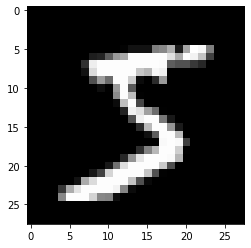

In [0]:
with tf.device('CPU:0'):
  cpu_model = build_model(allow_cudnn_kernel=True)
  cpu_model.set_weights(model.get_weights())
  result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
  print('Predicted result is: %s, target result is: %s' % (result.numpy(), sample_label))
  plt.imshow(sample, cmap=plt.get_cmap('gray'))


In [0]:
NestedInput = collections.namedtuple('NestedInput', ['feature1', 'feature2'])
NestedState = collections.namedtuple('NestedState', ['state1', 'state2'])
# using dictionary inputs
class NestedCell(tf.keras.layers.Layer):

  def __init__(self, unit_1, unit_2, unit_3, **kwargs):
    self.unit_1 = unit_1
    self.unit_2 = unit_2
    self.unit_3 = unit_3
    self.state_size = NestedState(state1=unit_1, 
                                  state2=tf.TensorShape([unit_2, unit_3]))
    self.output_size = (unit_1, tf.TensorShape([unit_2, unit_3]))
    super(NestedCell, self).__init__(**kwargs)

  def build(self, input_shapes):
    # expect input_shape to contain 2 items, [(batch, i1), (batch, i2, i3)]
    input_1 = input_shapes.feature1[1]
    input_2, input_3 = input_shapes.feature2[1:]

    self.kernel_1 = self.add_weight(
        shape=(input_1, self.unit_1), initializer='uniform', name='kernel_1')
    self.kernel_2_3 = self.add_weight(
        shape=(input_2, input_3, self.unit_2, self.unit_3),
        initializer='uniform',
        name='kernel_2_3')

  def call(self, inputs, states):
    # inputs should be in [(batch, input_1), (batch, input_2, input_3)]
    # state should be in shape [(batch, unit_1), (batch, unit_2, unit_3)]
    input_1, input_2 = tf.nest.flatten(inputs)
    s1, s2 = states

    output_1 = tf.matmul(input_1, self.kernel_1)
    output_2_3 = tf.einsum('bij,ijkl->bkl', input_2, self.kernel_2_3)
    state_1 = s1 + output_1
    state_2_3 = s2 + output_2_3

    output = [output_1, output_2_3]
    new_states = NestedState(state1=state_1, state2=state_2_3)

    return output, new_states


In [0]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

input_1 = 32
input_2 = 64
input_3 = 32
batch_size = 64
num_batch = 100
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = tf.keras.layers.RNN(cell)

inp_1 = tf.keras.Input((None, input_1))
inp_2 = tf.keras.Input((None, input_2, input_3))

outputs = rnn(NestedInput(feature1=inp_1, feature2=inp_2))

model = tf.keras.models.Model([inp_1, inp_2], outputs)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])


In [0]:
input_1_data = np.random.random((batch_size * num_batch, timestep, input_1))
input_2_data = np.random.random((batch_size * num_batch, timestep, input_2, input_3))
target_1_data = np.random.random((batch_size * num_batch, unit_1))
target_2_data = np.random.random((batch_size * num_batch, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]
# running model with completely random data, we get bad accuracy as expected
model.fit(input_data, target_data, batch_size=batch_size)
# TODO: data visualization

100/100 [==============================] - 76s 760ms/step - loss: 0.3840 - rnn_1_loss: 0.1234 - rnn_1_1_loss: 0.2606 - rnn_1_accuracy: 0.0962 - rnn_1_1_accuracy: 0.0335
